# Data Science Project
#### Christopher Healy D00270638
#### Using Data Science to predict the popularity of Reddit posts.

# Step 1: Business Understanding
Reddit is a highly popular social media platform that is used by a wide range of individuals, entrepeneurs, and businesses. It's popularity offers the potential of a global reach to posters across an extremely diverse range of topics.

### Audience:
Many people use Reddit as a means to promote themselves or their product. This includes but is not limited to:
- Entrepeneurs advertising products to niche markets.
- Musicians/performers trying to build a platform.
- "Influencers" trying to gain recognition.

The success/popularity of a Reddit post can be measured with "Karma", a numerical value which corresponds to the total sum of ratings on a post, i.e. upvotes minus downvotes.


### Aims of the project.
Determining how a Reddit post's Karma is influenced can allow these groups to achieve the maximum reach possible. By analysing the information associated with Reddit posts and comparing it to their popularity, I hope to answer:
1. How is post length connected to post success?
2. Is date/time of posting relevant to a post's success.
3. How does the "mood" found in a post's body influence its success?
4. How do attached photos impact post performance?
5. Are there any other factors that affect how a Reddit post will be received?

Posts can be analysed to determine their "mood" from their content, this will need to be done before any machine learning models can be trained. Similarly, if post photos are included in the data they will need to be classified in some way so that their influence on post Karma can be quantitatively seen.


# Step 2: Data Mining
The data is gathered from the Reddit API using the Python Reddit API Wrapper (praw).
Post information is gathered from a variety of popular subreddits to ensure a variety of themes and audiences.
The data fetched includes a variety of information on posts submitted to the following subreddits:
- r/funny
- r/todayilearned
- r/technology
- r/aww
- r/worldnews
- r/food
- r/gaming

See separate Jupyter Notebook "DataMining.ipynb"

# Step 3 - Data Cleaning
### Datapoints used:
| Variable      | Type                | Notes                                                         |
|---------------|---------------------|---------------------------------------------------------------|
| id            | Nominal Categorical | Ignore                                                        |
| title         | Nominal Categorical | Length of title is important, otherwise ignored               |
| subreddit     | Nominal Categorical | Explanatory                                                   |
| created_utc   | Discrete Numerical  | Used to determine is_weekend, then ignored                    |
| ups           | Discrete Numerical  | Explanatory                                                   |
| downs         | Discrete Numerical  | Explanatory                                                   |
| num_comments  | Discrete Numerical  | Explanatory                                                   |
| is_video      | Nominal Categorical | Explanatory                                                   |
| selftext      | Nominal Categorical | Length of text is important, otherwise ignored                |
| is_self       | Nominal Categorical | Explanatory                                                   |
| upvote_ratio  | Continous Numerical | Explanatory                                                   |
| title_length  | Discrete Numerical  | (Calculated Manually) Explanatory                             |
| post_length   | Discrete Numerical  | (Calculated Manually) Explanatory                             |
| is_weekend_post| Nominal Categorical | Explanatory                                                   |
| score         | Discrete Numerical  | Response Variable                                             |



In [21]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


In [22]:
#load and visualise data
reddit_data = pd.read_csv("reddit_data.csv", quotechar='"', escapechar='\\')
print("Data Info:")
print(reddit_data.info())
print("Data Head:")
print(reddit_data.head())



#check for issues in the numerical columns
print(reddit_data.describe())


#check no invalid values for categorical columns
print("\nUnique subreddits:")
print(reddit_data.subreddit.unique())
print("is_video field is only true/false?:")
print(reddit_data.is_video.unique())

print("is_self field is only true/false?:")
print(reddit_data.is_self.unique())

print("is is_weekend_post being calculated properly?:")
print(reddit_data.is_weekend_post.unique())

#ensure selftext is set to an empty string when blank
reddit_data["selftext"] = reddit_data["selftext"].fillna("")


#checking for null values in other fields
print("\nChecking for null values in df:")
fields_to_check_null = ["id", "title", "subreddit", "created_utc", "ups", "downs", "num_comments", "is_video", "is_self", "score", "upvote_ratio", "title_length", "post_length", "is_weekend_post"]
for field in fields_to_check_null:
    print(f"Null {field}:" + str(reddit_data[field].isnull().sum()))



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867 entries, 0 to 6866
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6867 non-null   object 
 1   title            6867 non-null   object 
 2   subreddit        6867 non-null   object 
 3   created_utc      6867 non-null   float64
 4   ups              6867 non-null   int64  
 5   downs            6867 non-null   int64  
 6   num_comments     6867 non-null   int64  
 7   is_video         6867 non-null   bool   
 8   selftext         1227 non-null   object 
 9   is_self          6867 non-null   bool   
 10  score            6867 non-null   int64  
 11  upvote_ratio     6867 non-null   float64
 12  title_length     6867 non-null   int64  
 13  post_length      6867 non-null   int64  
 14  is_weekend_post  6867 non-null   bool   
dtypes: bool(3), float64(2), int64(6), object(4)
memory usage: 664.0+ KB
None
Data Head:
        id 

### Findings during data cleaning
- The info on numerical columns shown with `reddit_data.info()` show figures in reasonable ranges with no problematic max or min values.
- The categorical columns show normal value, excluding "selftext" which is unique to each post.
- When the pandas dataframe is created, blank values in the "selftext" field appeared as NaN, these needed to be changed to empty string literals.
- Investigation showed that the data had no missing / null values other than those in the selftext field, which represents a post with no textual content.



# Step 4: Data Exploration

## Univariate Analysis
### created_utc


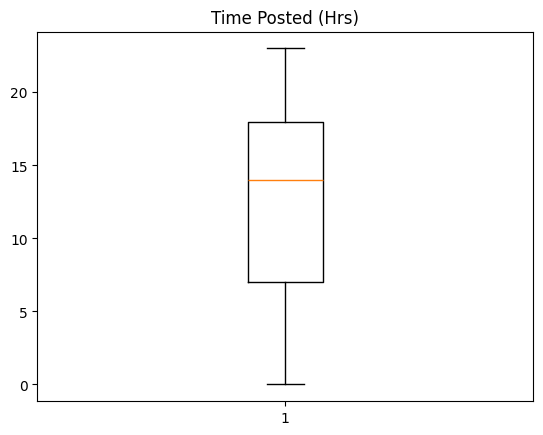

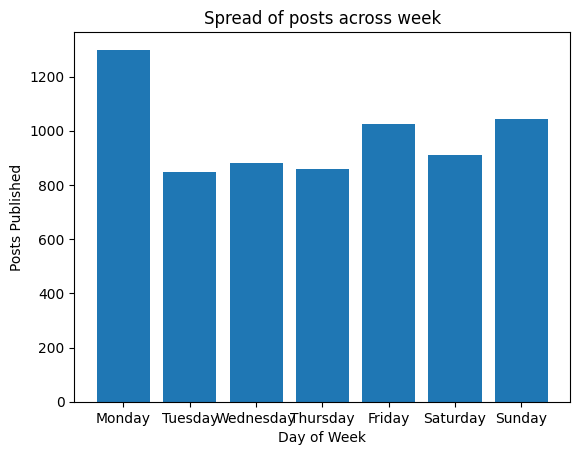

In [23]:
reddit_data["created_time"] = pd.to_datetime(reddit_data["created_utc"], unit="s", utc=True)

#plot data
#calculate average time of posting
time_as_hours = reddit_data["created_time"].dt.hour 
plt.boxplot(x=time_as_hours)
plt.title("Time Posted (Hrs)")
plt.show()

#calc spread across days of week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_info = reddit_data["created_time"].dt.day_name()
day_counts = days_info.value_counts().reindex(days_of_week, fill_value=0)
plt.bar(day_counts.index, day_counts.values)
plt.xlabel("Day of Week")
plt.ylabel("Posts Published")
plt.title("Spread of posts across week")
plt.show()


### Analysis of utc_created
Most of the posts are published between 12pm and 3pm, there is a wide deviation however with most of the posts published between 6am and 5pm.
There is a jump in the number of posts published on Mondays, while the posts across all other days of the week are relatively similar, with a gradual increase as the week progresses.

### Ups and Downs
This deals with the number of upvotes and downvotes each post receives.


UPVOTES
Mean number of upvotes 2108.5832241153344
Standard deviation of upvotes 6550.981739088913


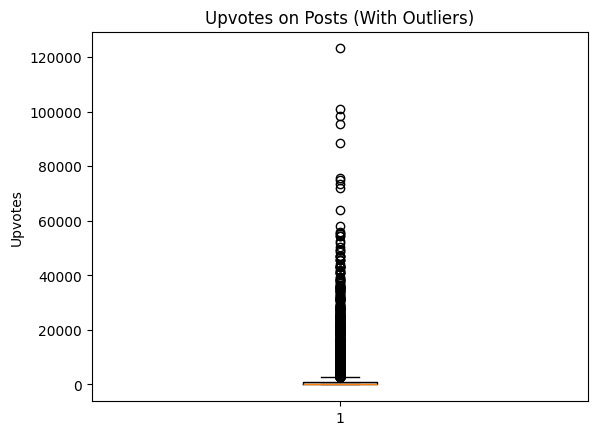

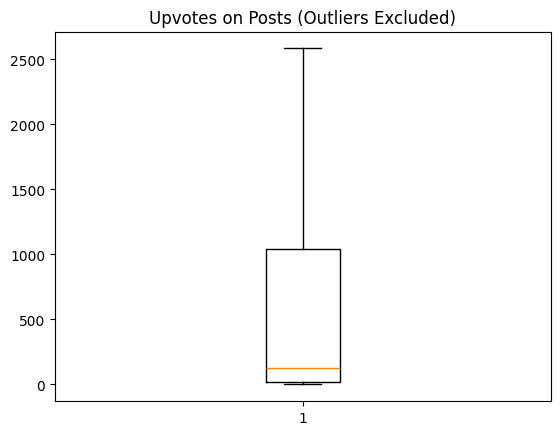

DOWNVOTES
downs
0    6867
Name: count, dtype: int64
Mean number of downvotes 0.0
Standard deviation of donwvotes 0.0
SCORE
Mean score 2108.5832241153344
Standard deviation of score 6550.981739088913


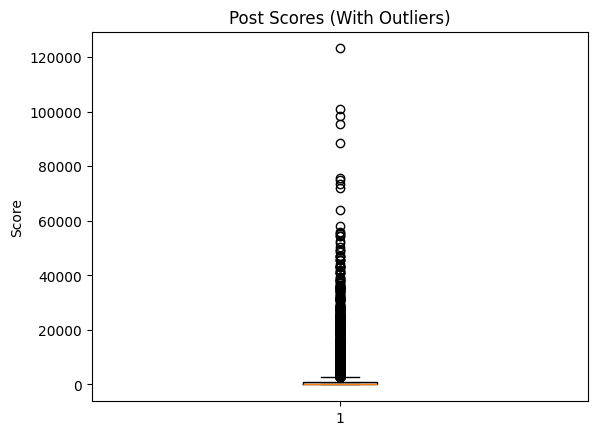

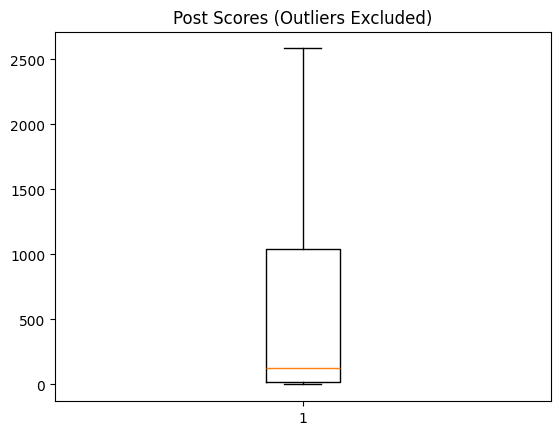

In [24]:
#ups
print("UPVOTES")
print("Mean number of upvotes", reddit_data["ups"].mean())
print("Standard deviation of upvotes", reddit_data["ups"].std())
plt.boxplot(x=reddit_data["ups"])
plt.title("Upvotes on Posts (With Outliers)")
plt.ylabel("Upvotes")
plt.show()

plt.boxplot(x=reddit_data["ups"], showfliers=False)
plt.title("Upvotes on Posts (Outliers Excluded)")
plt.show()

#downs
print("DOWNVOTES")
print(reddit_data["downs"].value_counts()) # downvotes are essentially irrelevant / not present on most posts.

print("Mean number of downvotes", reddit_data["downs"].mean())
print("Standard deviation of donwvotes", reddit_data["downs"].std())




#score
print("SCORE")
print("Mean score", reddit_data["score"].mean())
print("Standard deviation of score", reddit_data["score"].std())
plt.boxplot(x=reddit_data["score"])
plt.title("Post Scores (With Outliers)")
plt.ylabel("Score")
plt.show()

plt.boxplot(x=reddit_data["score"], showfliers=False)
plt.title("Post Scores (Outliers Excluded)")
plt.show()


### Analysis of ups, downs, and score

It is clear from the boxplots that the average upvotes of posts is reasonably low, with the data being skewed by a handful of posts with extremely high numbers of upvotes.
With the outliers excluded, the mean number lies around 100, with posts occasional breaking through and achieving 50000+ upvotes.

Downvotes are in most posts simply not present, or not present in any amount meaningful enough to affect the data. This can likely be attributed to most posts not getting much interaction at all.

As a result of this, number of upvotes and score show essentially the same graphs, as the downvotes have a negligible effect on score in the vast majority of posts.

### Num Comments:

Mean Number of comments:  98.85291976117664
Standard deviation of number of comments:  251.07820493627585


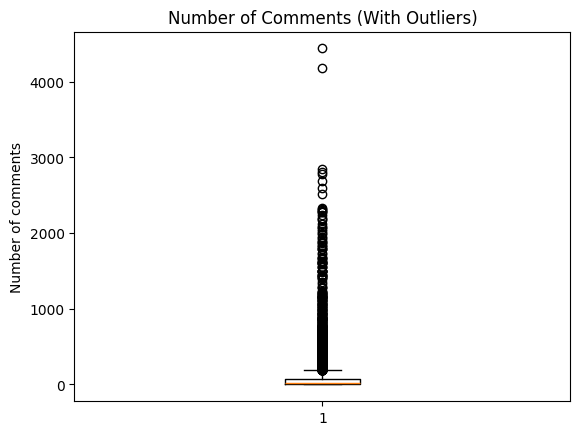

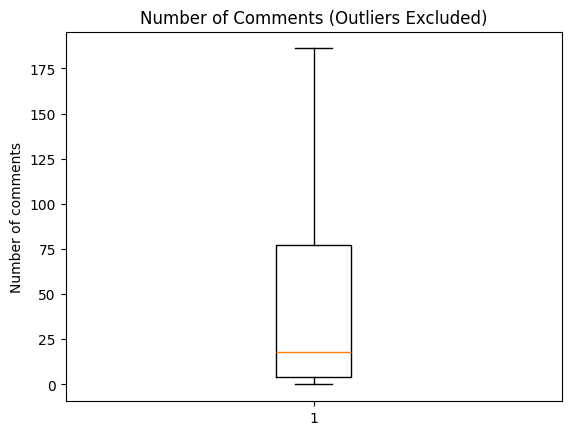

In [25]:
print("Mean Number of comments: ", reddit_data["num_comments"].mean())
print("Standard deviation of number of comments: ", reddit_data["num_comments"].std())

plt.boxplot(x=reddit_data["num_comments"])
plt.title("Number of Comments (With Outliers)")
plt.ylabel("Number of comments")
plt.show()


plt.boxplot(x=reddit_data["num_comments"], showfliers=False)
plt.title("Number of Comments (Outliers Excluded)")
plt.ylabel("Number of comments")
plt.show()






Similar to upvotes, and score. The mean number of comments posts have is skewed greatly by a group of ultra successful posts.
When outliers are excluded the average number of comments drops from 98 to approximately 10-20, with a large number receiving 0 or close to 0

## Bivariate Analysis
How do different variables correlate with the score?

Correlation between post length and score
[[ 1.         -0.05253084]
 [-0.05253084  1.        ]]


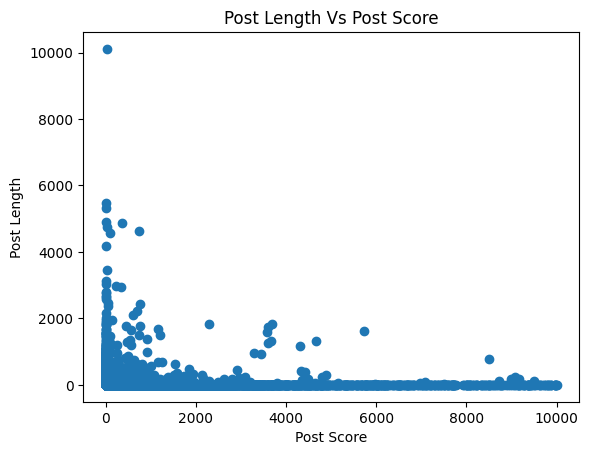

Correlation between num comments and score
[[1.         0.58505086]
 [0.58505086 1.        ]]


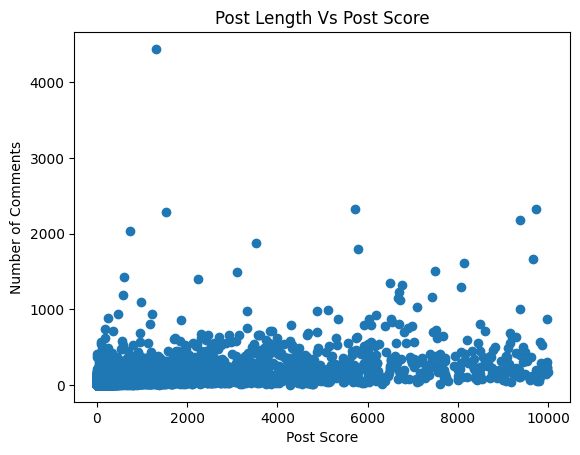

In [26]:
df_no_outliers = reddit_data[reddit_data["score"] <= 10000]

#post length and score
print("Correlation between post length and score")
print(np.corrcoef(reddit_data["post_length"], reddit_data["score"]))
plt.scatter(df_no_outliers["score"], df_no_outliers["post_length"])
plt.ylabel("Post Length")
plt.xlabel("Post Score")
plt.title("Post Length Vs Post Score")
plt.show()

#num comments and score
print("Correlation between num comments and score")
print(np.corrcoef(reddit_data["num_comments"], reddit_data["score"]))
plt.scatter(df_no_outliers["score"], df_no_outliers["num_comments"])
plt.ylabel("Number of Comments")
plt.xlabel("Post Score")
plt.title("Post Length Vs Post Score")
plt.show()



How do the score distributions between weekend posts and weekday posts differ?

Mean score of weekend posts:  2340.2670076726345
Mean score of weekday posts:  2016.3719462540716


Text(0.5, 1.0, 'Score Distribtuion of weekend vs weekday posts')

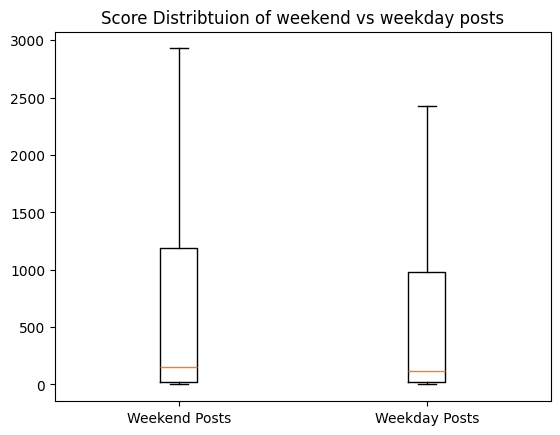

In [27]:
weekend_posts = reddit_data[reddit_data["is_weekend_post"] == True]
weekday_posts = reddit_data[reddit_data["is_weekend_post"] == False]


print("Mean score of weekend posts: ", weekend_posts["score"].mean())
print("Mean score of weekday posts: ", weekday_posts["score"].mean())

plt.boxplot([weekend_posts["score"], weekday_posts["score"]], showfliers=False)
plt.xticks([1, 2], ["Weekend Posts", "Weekday Posts"])
plt.title("Score Distribtuion of weekend vs weekday posts")


When averages are excluded the average scores for weekend and weekday posts are similar, however the weekend posts show a greater deviation in score, with weekend posts being noticeably more likely to reach higher levels of success. This suggests that weekend posts may be more likely to "break through" and reach a greater audience.

## Subreddit's impact on score 

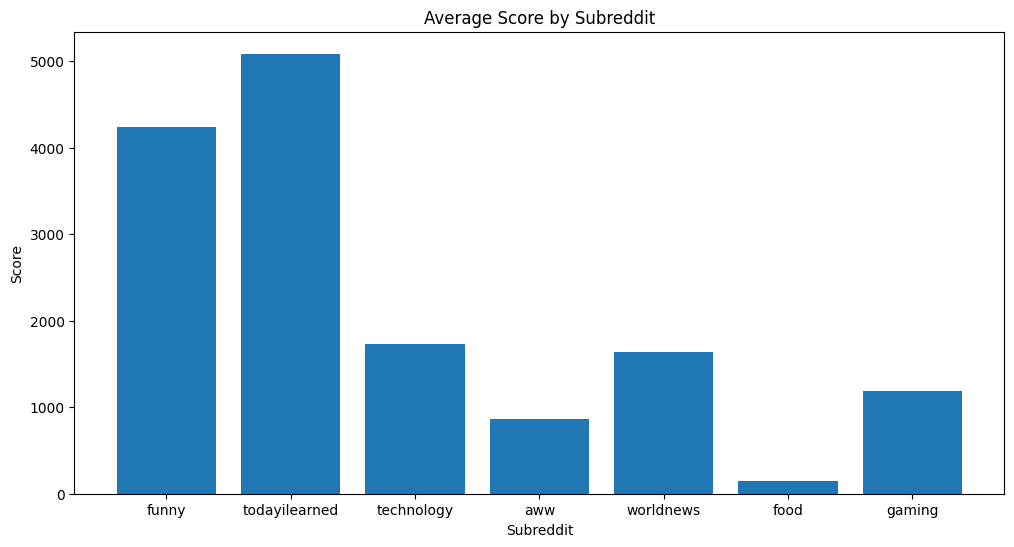

In [28]:
subreddits = reddit_data.subreddit.unique()
sub_averages = {}
for sub in subreddits:
    sub_posts = reddit_data[reddit_data["subreddit"]==sub]
    sub_averages[sub] = sub_posts["score"].mean()

plt.figure(figsize=(12,6))
plt.bar(sub_averages.keys(), sub_averages.values())
plt.title("Average Score by Subreddit")
plt.ylabel("Score")
plt.xlabel("Subreddit")

plt.show()

### Impact of subreddit on score findings:
The subreddit the score is placed in seems to have a great impact on the success a post can expect to have. This may suggest that certain subs are more reactive or that there is simple strength in numbers when posting to subreddits with a larger audience.


# Step 6: Feature Engineering

<Figure size 800x800 with 0 Axes>

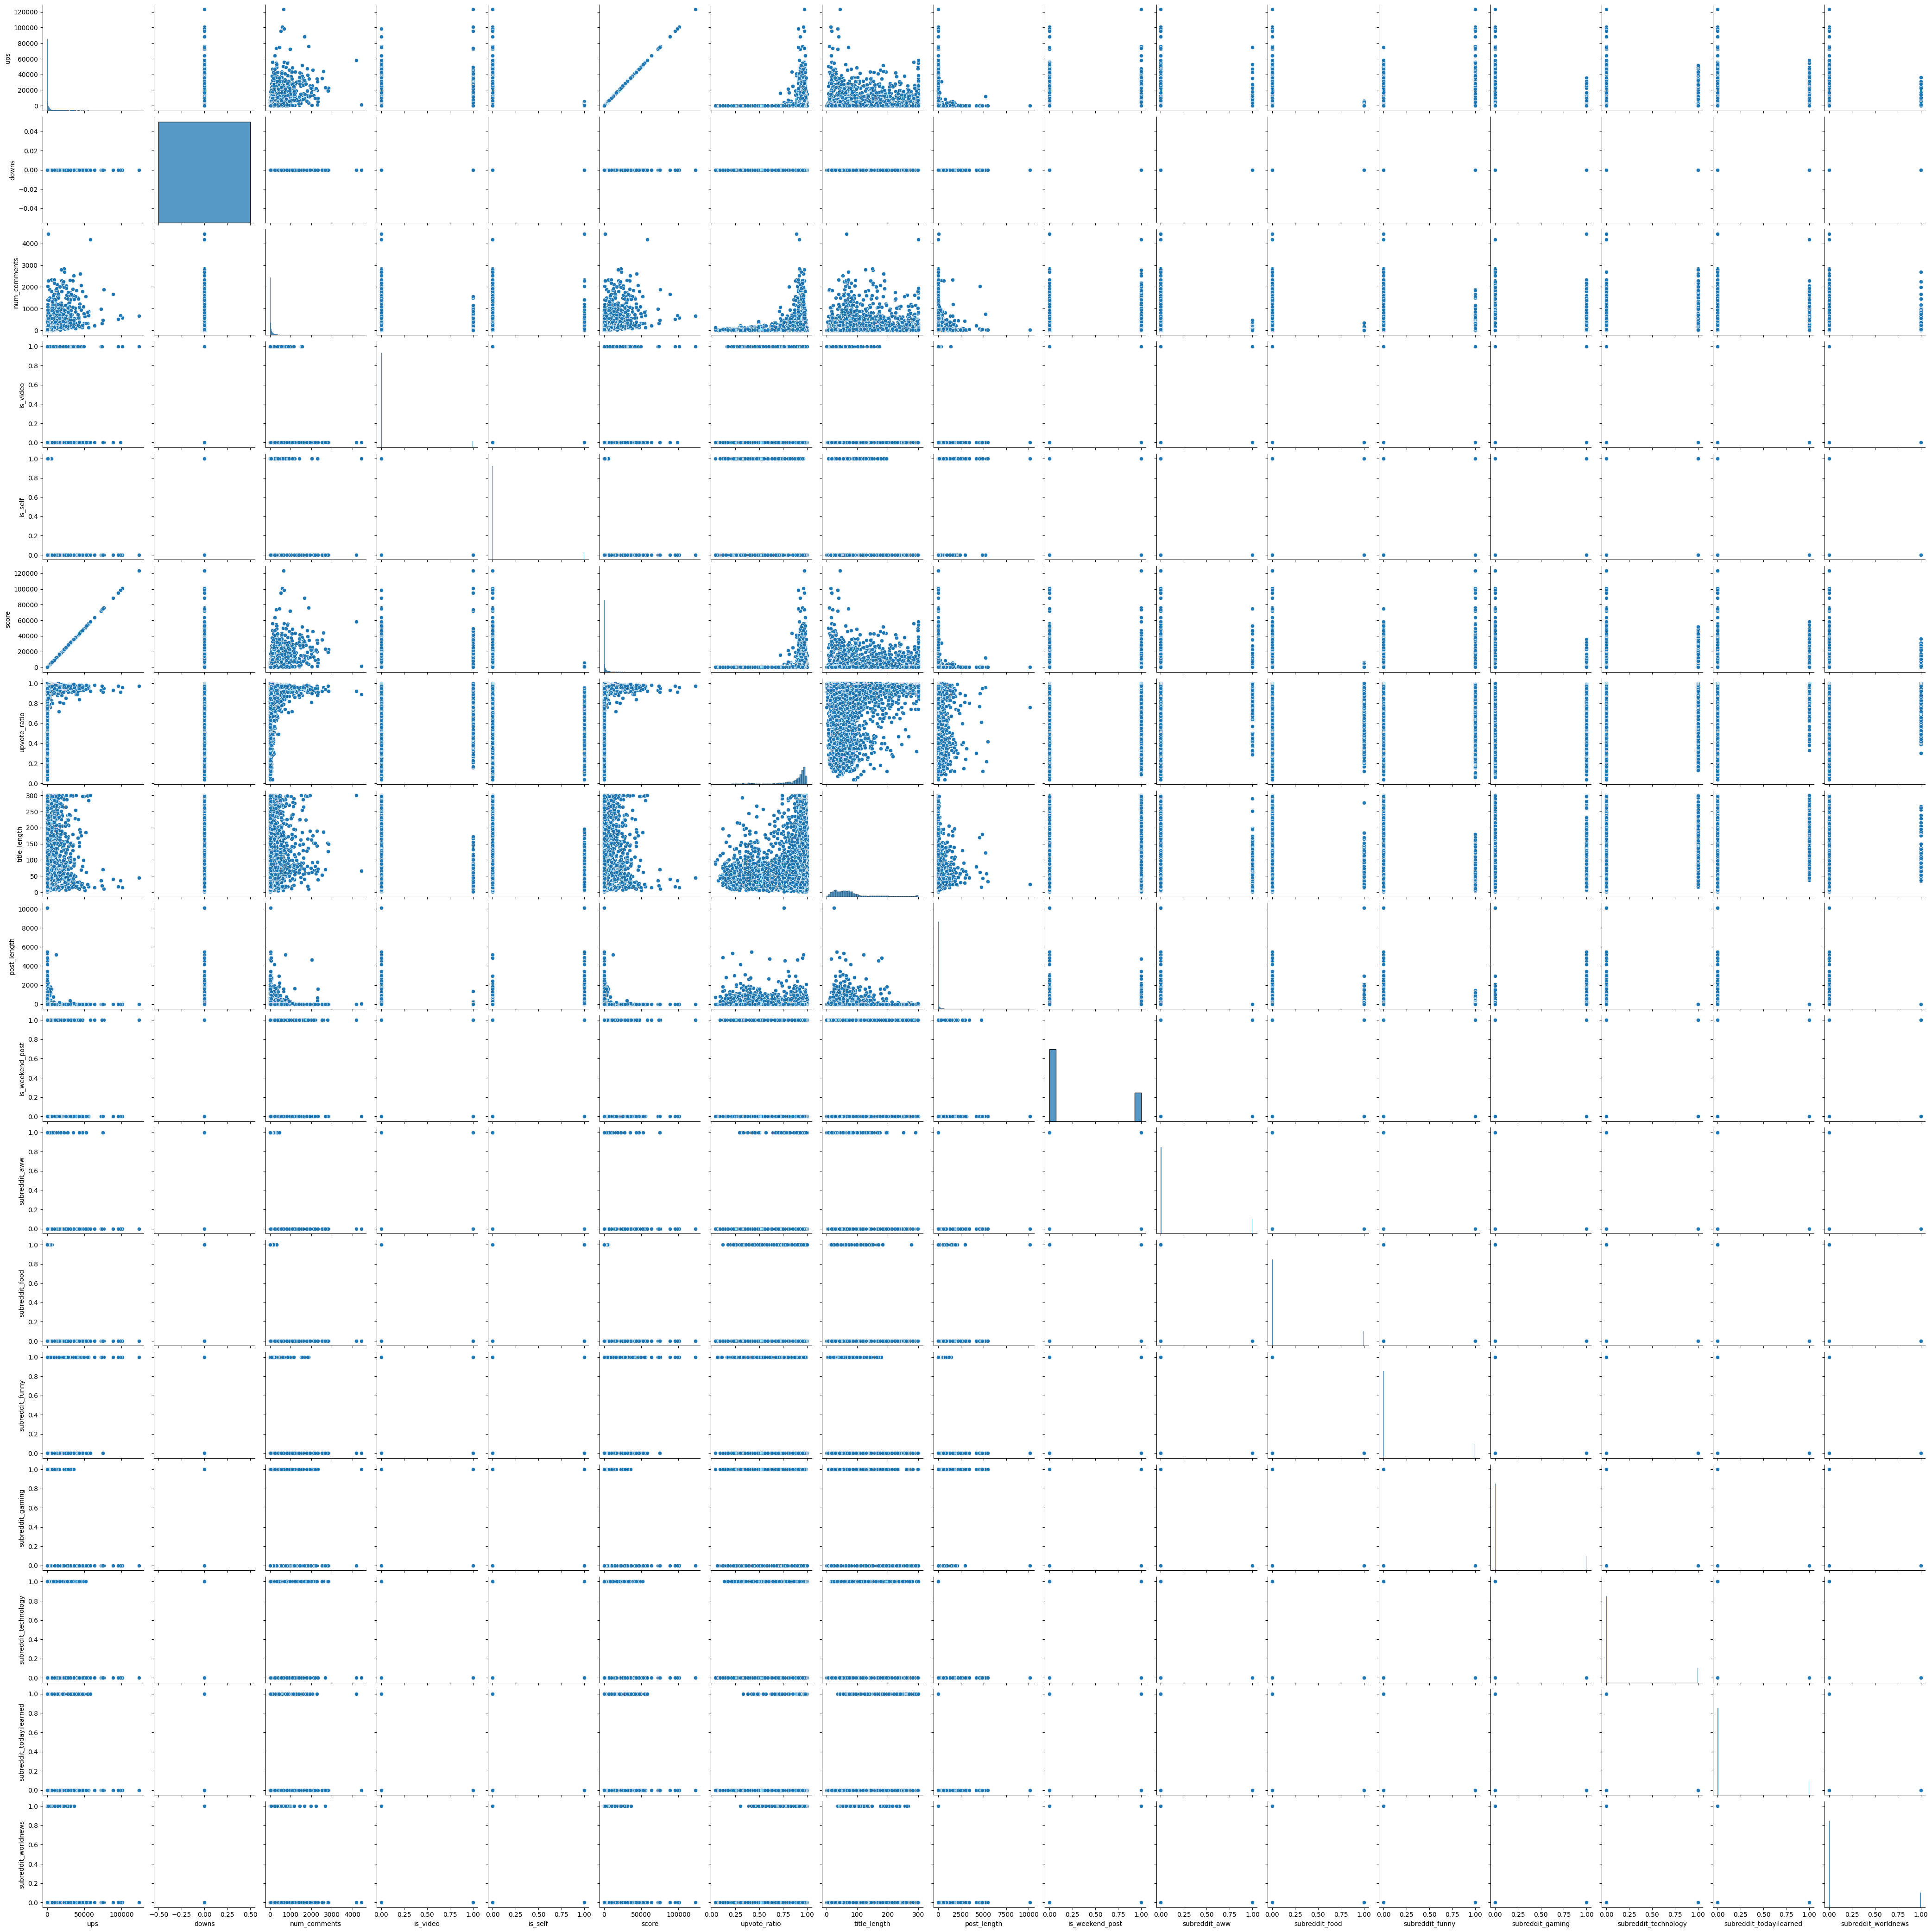

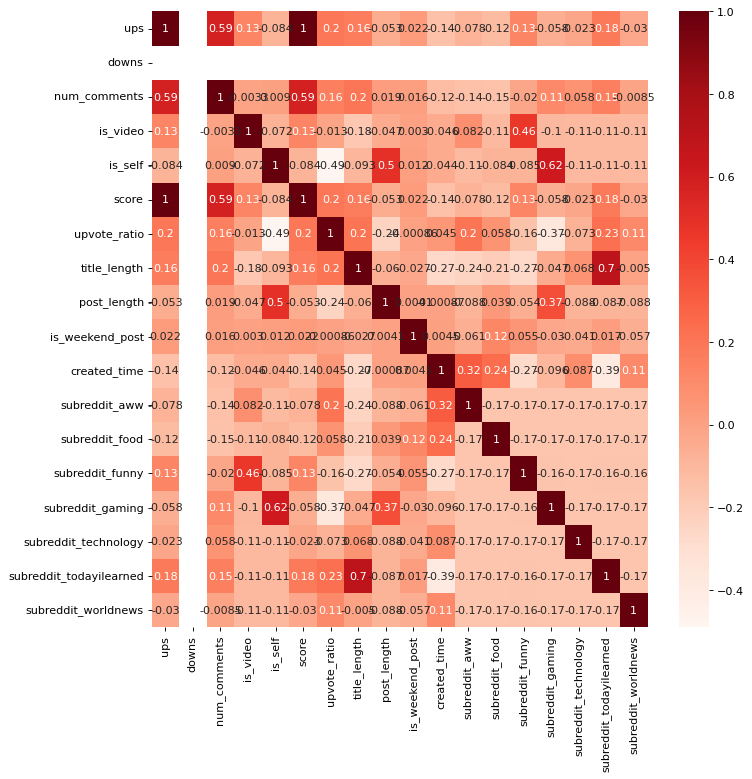

In [29]:
#remove unnecessary fields
created_utc_temp = reddit_data["created_utc"]
for field in ["id", "title", "created_utc", "selftext"]:
    if field in reddit_data.columns:
        reddit_data.drop(field, axis=1, inplace=True)

#generate scatter and correlation plots
#turn subs into their own fields
reddit_subs_encoded = pd.get_dummies(reddit_data, columns=["subreddit"])
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
sns.pairplot(reddit_subs_encoded)

#heatmap
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(reddit_subs_encoded.corr(), annot=True, cmap = 'Reds')
plt.show()





From the plots and heatmaps it is clear that "ups" and "score" can be treated as co-linear, this is understandable given that "downs" has a negligible effect on the final score in most posts.
The heatmap shows that "num_comments" could be a promising variable, subreddit may have an impact, while "is_video" and "upvote_ratio" have some slight influence.

From this analysis, I made the choice to remove the ups column, and focus on num_comments, the subreddit dummies and is_video as the main explanatory variables.

In [30]:
if "ups" in reddit_subs_encoded.columns:
    reddit_subs_encoded.drop("ups", axis=1, inplace=True)

# Step 6: Predictive Modelling
## Model 1 - Linear Regression
### 1. Train-Test Split

In [35]:
#response and predictor vars
x = reddit_subs_encoded[["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_time", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]]


y = reddit_subs_encoded["score"]

x["is_video"] = x["is_video"].astype(int)
x["is_self"] = x["is_self"].astype(int)
x["created_utc"] = created_utc_temp


for sub in ["subreddit_food", "subreddit_aww",
            "subreddit_funny", "subreddit_gaming", "subreddit_technology",
            "subreddit_todayilearned", "subreddit_worldnews"]:
    x[sub] = x[sub].astype(int)

x.drop("created_time", axis=1, inplace=True)



#split 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=444)

y_train
x_train




C:\Users\chris\AppData\Local\Temp\ipykernel_18440\2369076714.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["is_video"] = x["is_video"].astype(int)
C:\Users\chris\AppData\Local\Temp\ipykernel_18440\2369076714.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["is_self"] = x["is_self"].astype(int)
C:\Users\chris\AppData\Local\Temp\ipykernel_18440\2369076714.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,num_comments,is_video,is_self,upvote_ratio,title_length,post_length,subreddit_food,subreddit_aww,subreddit_funny,subreddit_gaming,subreddit_technology,subreddit_todayilearned,subreddit_worldnews,created_utc
5425,2,0,0,0.90,18,33,1,0,0,0,0,0,0,1.762924e+09
5484,4,0,0,0.97,28,0,1,0,0,0,0,0,0,1.762857e+09
4665,60,0,0,0.91,96,0,0,0,0,0,0,0,1,1.762393e+09
2422,124,0,0,0.97,156,0,0,0,0,0,1,0,0,1.762709e+09
3025,0,0,0,0.88,30,0,0,1,0,0,0,0,0,1.763380e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6631,66,0,1,0.13,43,282,0,0,0,1,0,0,0,1.761830e+09
948,11,0,0,0.38,63,59,0,0,1,0,0,0,0,1.760781e+09
4163,3,0,0,0.94,67,0,0,0,0,0,0,0,1,1.763062e+09
3336,4,0,0,0.97,49,0,0,1,0,0,0,0,0,1.763147e+09


### 2: Regression Modelling
Stepwise Forward approach.

In [37]:
modelVariables = []
candidateVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]

#model 1:
for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ":" + str(model.rsquared_adj))

#best var is num_comments: 0.32529

num_comments:0.3253973222964396
is_video:0.016606254951093247
is_self:0.006929620404040215
upvote_ratio:0.037887367012382156
title_length:0.02492317239383879
post_length:0.002768955218984237
created_utc:0.01871606829502115
subreddit_food:0.014767462543648802
subreddit_aww:0.0063296346761239075
subreddit_funny:0.0176424552080795
subreddit_gaming:0.004278449073585322
subreddit_technology:0.0002792716286790231
subreddit_todayilearned:0.03445479433029619
subreddit_worldnews:0.0005473441989007899


In [40]:
#model 2:
modelVariables = ["num_comments"]
candidateVariables = ["is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var: subreddit_funny 0.3459


is_video: 0.34300838650093424
is_self: 0.333418126111231
upvote_ratio: 0.33597672417540836
title_length: 0.3274850371239658
post_length: 0.3282686523566546
created_utc: 0.3301452135591072
subreddit_food: 0.32658414536250713
subreddit_aww: 0.32528218280900234
subreddit_funny: 0.3459366445321498
subreddit_gaming: 0.3416117199811636
subreddit_technology: 0.3283898171061955
subreddit_todayilearned: 0.33448989137711826
subreddit_worldnews: 0.325782165894421


In [42]:
#model 2:
modelVariables = ["num_comments", "subreddit_funny"]
candidateVariables = ["is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var - todayilearned: 0.3605592091093953

is_video: 0.3514644245389065
is_self: 0.35179640681704805
upvote_ratio: 0.36184819970339144
title_length: 0.35399467006436847
post_length: 0.3479502212126071
created_utc: 0.34678097977124056
subreddit_food: 0.34594936634880613
subreddit_aww: 0.3465959574909212
subreddit_gaming: 0.3569177363364767
subreddit_technology: 0.346880329969817
subreddit_todayilearned: 0.3605592091093953
subreddit_worldnews: 0.3458206844825964


In [ ]:
#model 3:
modelVariables = ["num_comments", "subreddit_funny", "subreddit_todayilearned"]
candidateVariables = ["is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_gaming", "subreddit_technology",
                        "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var - upvote_ratio: 0.3716370369541112

is_video: 0.36677684304523495
is_self: 0.36426741276715746
upvote_ratio: 0.3716370369541112
title_length: 0.36056805342717946
post_length: 0.3616066361857875
created_utc: 0.36108984030860747
subreddit_food: 0.36055178612873273
subreddit_aww: 0.3629843304310859
subreddit_gaming: 0.366956478613506
subreddit_technology: 0.36049855431010314
subreddit_worldnews: 0.36115889963792136


In [ ]:
#model 4:
modelVariables = ["num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio"]
candidateVariables = ["is_video", "is_self",
                        "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_gaming", "subreddit_technology",
                        "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var - is_video: 0.3767196552508083

is_video: 0.3767196552508083
is_self: 0.3715984332328862
title_length: 0.37160046988109485
post_length: 0.37155669197350727
created_utc: 0.37166943034044586
subreddit_food: 0.3715225271104532
subreddit_aww: 0.3721367014446828
subreddit_gaming: 0.3731327623575208
subreddit_technology: 0.37152251880227705
subreddit_worldnews: 0.3716730162182862


In [46]:
#model 5:
modelVariables = ["num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio", "is_video"]
candidateVariables = ["is_self",
                        "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_gaming", "subreddit_technology",
                        "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var - subreddit_gaming: 0.3781398372382163

is_self: 0.3766788136108854
title_length: 0.3767716037868779
post_length: 0.3766345762747688
created_utc: 0.3766397699382097
subreddit_food: 0.3766200698709332
subreddit_aww: 0.37678334520492085
subreddit_gaming: 0.3781398372382163
subreddit_technology: 0.37661383131314574
subreddit_worldnews: 0.3768699271851045


In [ ]:
#model 6:
modelVariables = ["num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio", "is_video", "subreddit_gaming"]
candidateVariables = ["is_self",
                        "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_technology",
                        "subreddit_worldnews"]

for var in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables + [var]])).fit()
    print(var + ": "+ str(model.rsquared_adj))

#best var - title_length: 0.37825308269984437

is_self: 0.37820577015487156
title_length: 0.37825308269984437
post_length: 0.37806533667245124
created_utc: 0.37804197605057177
subreddit_food: 0.3780507893200803
subreddit_aww: 0.3780831107130215
subreddit_technology: 0.3781358476453184
subreddit_worldnews: 0.3780855589229183


### Stepwise Forwards Results

After the 6 iterations, adding features to the model is now giving diminishing returns and risks overfitting.
The best model worked on variables "num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio", "is_video", "subreddit_gaming",
and reached a max accuracy of 0.37825

## Stepwise Backwards Approach

In [ ]:
#model with all variables (14)
modelVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]

model = sm.OLS(y_train, sm.add_constant(x_train[modelVariables])).fit()
print("Rsq Adj: "+ str(model.rsquared_adj))


Rsq Adj: 0.378080541887601


In [54]:
#model with 13 variables
modelVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]
candidateVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length", "post_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]


for varC in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[[var for var in modelVariables if var!=varC]])).fit()
    print(varC + ": "+ str(model.rsquared_adj))

#remove post_length: 0.3781908231924016

num_comments: 0.11548558925733066
is_video: 0.3732767943332169
is_self: 0.378039002917121
upvote_ratio: 0.37356600062115164
title_length: 0.37784071791284246
post_length: 0.3781908231924016
created_utc: 0.3781643430002306
subreddit_food: 0.3780805418876011
subreddit_aww: 0.3780805418876013
subreddit_funny: 0.378080541887601
subreddit_gaming: 0.3780805418876011
subreddit_technology: 0.378080541887601
subreddit_todayilearned: 0.3780805418876011
subreddit_worldnews: 0.3780805418876011


In [ ]:
#model with 12 variables
modelVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]
candidateVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length",
                        "created_utc", "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]


for varC in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[[var for var in modelVariables if var!=varC]])).fit()
    print(varC + ": "+ str(model.rsquared_adj))

#remove created_utc: 0.3782748338336349

num_comments: 0.11564664311665529
is_video: 0.3733879423811095
is_self: 0.3781093034232875
upvote_ratio: 0.3736784591232014
title_length: 0.37794918093119045
created_utc: 0.3782748338336349
subreddit_food: 0.37819082319240127
subreddit_aww: 0.37819082319240127
subreddit_funny: 0.3781908231924014
subreddit_gaming: 0.37819082319240116
subreddit_technology: 0.3781908231924014
subreddit_todayilearned: 0.3781908231924014
subreddit_worldnews: 0.3781908231924014


In [ ]:
#model with 11 variables
modelVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length",
                         "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]
candidateVariables = ["num_comments", "is_video", "is_self",
                        "upvote_ratio", "title_length",
                        "subreddit_food", "subreddit_aww",
                        "subreddit_funny", "subreddit_gaming", "subreddit_technology",
                        "subreddit_todayilearned", "subreddit_worldnews"]


for varC in candidateVariables:
    model = sm.OLS(y_train, sm.add_constant(x_train[[var for var in modelVariables if var!=varC]])).fit()
    print(varC + ": "+ str(model.rsquared_adj))

#remove none, best performer found

num_comments: 0.11580747414216841
is_video: 0.3735011515186799
is_self: 0.378196398394107
upvote_ratio: 0.3737474109374508
title_length: 0.3780327808488859
subreddit_food: 0.3782748338336348
subreddit_aww: 0.3782748338336349
subreddit_funny: 0.3782748338336349
subreddit_gaming: 0.3782748338336349
subreddit_technology: 0.3782748338336349
subreddit_todayilearned: 0.378274833833635
subreddit_worldnews: 0.3782748338336349


### Stepwise backwards results:
The model stopped showing meaningful improvement with 11 variables remaining.
Using the stepwise backwards approach the model reached a maximum accuracy of 0.3782748338336349

### Statement of Best Model

In [58]:
modelFinal = sm.OLS(y_train, sm.add_constant(x_train[["num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio", "is_video", "subreddit_gaming"]])).fit()
print(modelFinal.params)

const                     -2305.125681
num_comments                 14.956198
subreddit_funny            2456.974743
subreddit_todayilearned    1960.035934
upvote_ratio               2798.951681
is_video                   2193.676033
subreddit_gaming           -865.859085
dtype: float64


In [ ]:
#Calculate the Summary Measures MAE (Mean Absolute Error), MAPE(Mean Absolute Percentage Error) and the RMSE (Root Mean Square Error) for the model based on the TEST set.
#These give a measure of the quality of the predictions

x_test_evaluate = sm.add_constant(x_test[["num_comments", "subreddit_funny", "subreddit_todayilearned", "upvote_ratio", "is_video", "subreddit_gaming"]]) #Add constant to model
ypred_test = modelFinal.predict(x_test_evaluate)


Prediction_test_MAE = sum(abs(ypred_test - y_test))/len(y_test)
Prediction_test_MAPE = sum(abs((ypred_test - y_test)/y_test))/len(y_test)
Prediction_test_RMSE = (sum((ypred_test - y_test)**2)/len(y_test))**0.5

print(Prediction_test_MAE) #1884
print(Prediction_test_MAPE) #inf (fix)
print(Prediction_test_RMSE) #4171


1884.7289964824413
inf
4171.777482956153


### Is the Regression Model acceptable for use?
Regresssion models have not performed well on this dataset, consistently showing low accuracy and high error ranges.
From these results it is easy to conclude that this model should not be used in any scenario where accuracy matters.


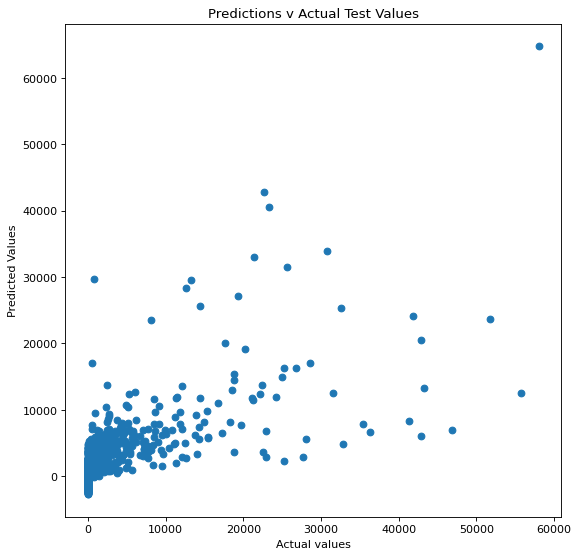

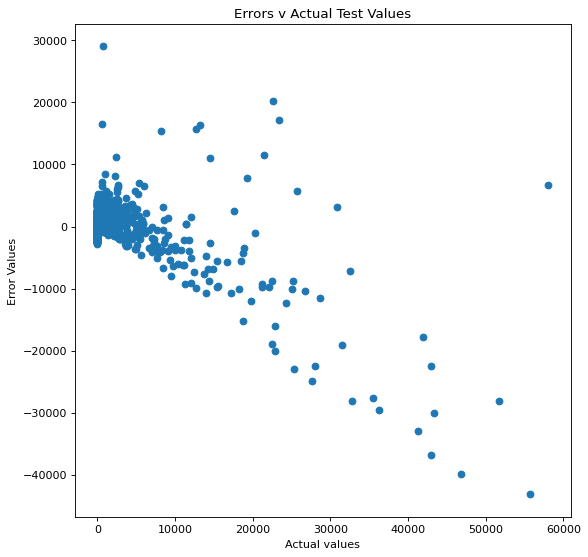

In [60]:
#Explore how the errors depend on key variables
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(y_test, ypred_test)
plt.title("Predictions v Actual Test Values")
plt.xlabel("Actual values")
plt.ylabel("Predicted Values")
plt.show() #Should be close to a straight line

#Plot the error values against the actual value
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(y_test, ypred_test - y_test)
plt.title("Errors v Actual Test Values")
plt.xlabel("Actual values")
plt.ylabel("Error Values")
plt.show()

## Model 2: Neural Networks
Neural Networks may be better suited to predicting the score of posts in this dataset.
